<a href="https://colab.research.google.com/github/Undasnr/DL-ML/blob/main/Ronny_SimpleConv2d_Assignment_Correction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading and preparing MNIST data...
Downloaded train-images-idx3-ubyte.gz.
Downloaded train-labels-idx1-ubyte.gz.
Downloaded t10k-images-idx3-ubyte.gz.
Downloaded t10k-labels-idx1-ubyte.gz.
Unzipping train-images-idx3-ubyte.gz...
Unzipped train-images-idx3-ubyte.gz.
Unzipping train-labels-idx1-ubyte.gz...
Unzipped train-labels-idx1-ubyte.gz.
Unzipping t10k-images-idx3-ubyte.gz...
Unzipped t10k-images-idx3-ubyte.gz.
Unzipping t10k-labels-idx1-ubyte.gz...
Unzipped t10k-labels-idx1-ubyte.gz.
Data loaded successfully. Training set: (60000, 1, 28, 28), Test set: (10000, 1, 28, 28)


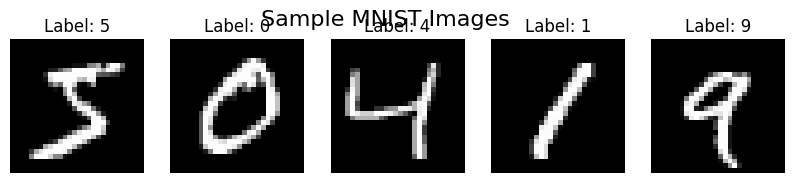

Starting training with 937 batches per epoch...
Epoch 1/3, Average Loss: 0.2263, Validation Accuracy: 96.89%
Epoch 2/3, Average Loss: 0.0880, Validation Accuracy: 97.96%
Epoch 3/3, Average Loss: 0.0640, Validation Accuracy: 97.94%

Training complete.


In [1]:
!pip install python-mnist

import numpy as np
import random
import os
import requests
import gzip
import matplotlib.pyplot as plt
from mnist import MNIST

# Optimized Layer Implementations

class Conv2d:
    """
    An optimized 2D convolutional layer using vectorized operations.
    """
    def __init__(self, in_channels, out_channels, filter_size, padding=0, stride=1):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.filter_h, self.filter_w = filter_size
        self.padding = padding
        self.stride = stride

        # He initialization for better convergence
        self.W = np.random.randn(out_channels, in_channels, self.filter_h, self.filter_w) * np.sqrt(2.0 / (in_channels * self.filter_h * self.filter_w))
        self.b = np.zeros((1, out_channels, 1, 1))

        self.dW = None
        self.db = None
        self.X = None
        self.X_padded = None
        self.output_shape = None

    def forward(self, X):
        self.X = X
        N, C, H, W = X.shape

        # Calculate output dimensions
        H_out = (H + 2 * self.padding - self.filter_h) // self.stride + 1
        W_out = (W + 2 * self.padding - self.filter_w) // self.stride + 1
        self.output_shape = (N, self.out_channels, H_out, W_out)

        # Pad the input
        if self.padding > 0:
            self.X_padded = np.pad(X, ((0, 0), (0, 0), (self.padding, self.padding),
                                      (self.padding, self.padding)), mode='constant')
        else:
            self.X_padded = X

        # Use im2col technique for vectorization
        cols = self.im2col(self.X_padded, self.filter_h, self.filter_w, self.stride)
        W_reshaped = self.W.reshape(self.out_channels, -1).T

        # Perform convolution as a single matrix multiplication
        output = np.dot(cols, W_reshaped) + self.b.reshape(1, -1)
        output = output.reshape(N, H_out, W_out, self.out_channels).transpose(0, 3, 1, 2)

        return output

    def im2col(self, X, filter_h, filter_w, stride):
        N, C, H, W = X.shape
        H_out = (H - filter_h) // stride + 1
        W_out = (W - filter_w) // stride + 1

        # Create matrix of image patches
        cols = np.zeros((N, C, filter_h, filter_w, H_out, W_out))
        for h in range(filter_h):
            h_end = h + H_out * stride
            for w in range(filter_w):
                w_end = w + W_out * stride
                cols[:, :, h, w, :, :] = X[:, :, h:h_end:stride, w:w_end:stride]

        cols = cols.transpose(0, 4, 5, 1, 2, 3).reshape(N * H_out * W_out, -1)
        return cols

    def col2im(self, cols, X_shape, filter_h, filter_w, stride):
        N, C, H, W = X_shape
        H_out = (H - filter_h) // stride + 1
        W_out = (W - filter_w) // stride + 1

        # Convert columns back to image format
        cols = cols.reshape(N, H_out, W_out, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)
        X = np.zeros(X_shape)

        for h in range(filter_h):
            h_end = h + H_out * stride
            for w in range(filter_w):
                w_end = w + W_out * stride
                X[:, :, h:h_end:stride, w:w_end:stride] += cols[:, :, h, w, :, :]

        return X

    def backward(self, dA):
        N, C, H, W = self.X.shape
        dA_reshaped = dA.transpose(0, 2, 3, 1).reshape(-1, self.out_channels)

        # Calculate gradients
        cols = self.im2col(self.X_padded, self.filter_h, self.filter_w, self.stride)
        self.dW = np.dot(cols.T, dA_reshaped).T.reshape(self.W.shape)
        self.db = np.sum(dA_reshaped, axis=0).reshape(self.b.shape)

        # Calculate input gradient
        dcols = np.dot(dA_reshaped, self.W.reshape(self.out_channels, -1))
        dX_padded = self.col2im(dcols, self.X_padded.shape,
                               self.filter_h, self.filter_w, self.stride)

        # Remove padding
        if self.padding > 0:
            dX = dX_padded[:, :, self.padding:-self.padding, self.padding:-self.padding]
        else:
            dX = dX_padded

        return dX


class ReLU:
    """
    Optimized ReLU activation function.
    """
    def __init__(self):
        self.mask = None

    def forward(self, X):
        self.mask = (X <= 0)
        out = X.copy()
        out[self.mask] = 0
        return out

    def backward(self, dA):
        dA[self.mask] = 0
        return dA


class MaxPool2D:
    """
    Optimized 2D maximum pooling layer.
    """
    def __init__(self, pool_size, stride):
        self.pool_h, self.pool_w = pool_size
        self.stride = stride
        self.X = None
        self.arg_max = None

    def forward(self, X):
        self.X = X
        N, C, H, W = X.shape

        H_out = (H - self.pool_h) // self.stride + 1
        W_out = (W - self.pool_w) // self.stride + 1

        # Reshape input for vectorized operations
        X_reshaped = X.reshape(N, C, H // self.pool_h, self.pool_h,
                              W // self.pool_w, self.pool_w)

        # Find max values and their indices
        out = X_reshaped.max(axis=3).max(axis=4)
        self.arg_max = X_reshaped.argmax(axis=3).argmax(axis=4)

        return out

    def backward(self, dA):
        N, C, H_out, W_out = dA.shape
        dX = np.zeros_like(self.X)

        # Distribute gradients to max positions
        for n in range(N):
            for c in range(C):
                for i in range(H_out):
                    for j in range(W_out):
                        idx = self.arg_max[n, c, i, j]
                        i1, i2 = np.unravel_index(idx, (self.pool_h, self.pool_w))
                        dX[n, c, i*self.stride+i1, j*self.stride+i2] = dA[n, c, i, j]

        return dX


class Flatten:
    """
    Optimized flattening layer.
    """
    def __init__(self):
        self.input_shape = None

    def forward(self, X):
        self.input_shape = X.shape
        return X.reshape(X.shape[0], -1)

    def backward(self, dA):
        return dA.reshape(self.input_shape)


class Dense:
    """
    Optimized fully-connected layer.
    """
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        # He initialization
        self.W = np.random.randn(input_size, output_size) * np.sqrt(2.0 / input_size)
        self.b = np.zeros(output_size)
        self.X = None
        self.dW = None
        self.db = None

    def forward(self, X):
        self.X = X
        return np.dot(X, self.W) + self.b

    def backward(self, dA):
        self.dW = np.dot(self.X.T, dA)
        self.db = np.sum(dA, axis=0)
        return np.dot(dA, self.W.T)


# Loss Function
class CrossEntropyLoss:
    """
    Optimized Cross-Entropy Loss with Softmax.
    """
    def __init__(self):
        self.y_true = None
        self.softmax_output = None

    def forward(self, logits, y_true):
        self.y_true = y_true

        # Numerical stability
        logits = logits - np.max(logits, axis=1, keepdims=True)
        exp_logits = np.exp(logits)
        self.softmax_output = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

        # Calculate loss
        loss = -np.sum(y_true * np.log(self.softmax_output + 1e-12)) / logits.shape[0]
        return loss

    def backward(self):
        return (self.softmax_output - self.y_true) / self.y_true.shape[0]


# Optimizer - SGD with Mini-Batch Support
class SGD:
    """
    Stochastic Gradient Descent optimizer with mini-batch support.
    """
    def __init__(self, learning_rate=0.01, momentum=0.9):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.velocity = {}

    def update(self, layers):
        for i, layer in enumerate(layers):
            if hasattr(layer, 'W') and hasattr(layer, 'dW'):
                # Initialize velocity if not exists
                if i not in self.velocity:
                    self.velocity[i] = {'W': np.zeros_like(layer.W), 'b': np.zeros_like(layer.b)}

                # Update with momentum
                self.velocity[i]['W'] = self.momentum * self.velocity[i]['W'] - self.learning_rate * layer.dW
                self.velocity[i]['b'] = self.momentum * self.velocity[i]['b'] - self.learning_rate * layer.db

                layer.W += self.velocity[i]['W']
                layer.b += self.velocity[i]['b']


# Model and Training Loop
class LeNet:
    """
    Optimized LeNet-5 architecture.
    """
    def __init__(self):
        self.layers = [
            Conv2d(in_channels=1, out_channels=6, filter_size=(5, 5), padding=2),  # Added padding to maintain size
            ReLU(),
            MaxPool2D(pool_size=(2, 2), stride=2),
            Conv2d(in_channels=6, out_channels=16, filter_size=(5, 5)),
            ReLU(),
            MaxPool2D(pool_size=(2, 2), stride=2),
            Flatten(),
            Dense(input_size=16 * 5 * 5, output_size=120),  # Corrected input size
            ReLU(),
            Dense(input_size=120, output_size=84),
            ReLU(),
            Dense(input_size=84, output_size=10)
        ]

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X

    def backward(self, dA):
        for layer in reversed(self.layers):
            dA = layer.backward(dA)
        return dA


class Trainer:
    """
    Optimized trainer with mini-batch implementation.
    """
    def __init__(self, model, optimizer, loss_function, epochs=3, batch_size=64):
        self.model = model
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.epochs = epochs
        self.batch_size = batch_size
        self.log_loss = []
        self.log_acc = []

    def fit(self, X_train, y_train_one_hot, X_val, y_val):
        num_samples = len(X_train)
        num_batches = num_samples // self.batch_size
        print(f"Starting training with {num_batches} batches per epoch...")

        for epoch in range(self.epochs):
            epoch_loss = 0
            indices = np.random.permutation(num_samples)

            for i in range(num_batches):
                batch_indices = indices[i * self.batch_size:(i + 1) * self.batch_size]
                X_batch = X_train[batch_indices]
                y_batch_one_hot = y_train_one_hot[batch_indices]

                # Forward pass
                output = self.model.forward(X_batch)
                loss = self.loss_function.forward(output, y_batch_one_hot)
                epoch_loss += loss

                # Backward pass
                dA = self.loss_function.backward()
                self.model.backward(dA)

                # Update parameters
                self.optimizer.update(self.model.layers)

            avg_loss = epoch_loss / num_batches
            self.log_loss.append(avg_loss)

            # Validation
            val_preds = self.predict(X_val)
            val_accuracy = np.mean(val_preds == y_val)
            self.log_acc.append(val_accuracy)

            print(f"Epoch {epoch+1}/{self.epochs}, Average Loss: {avg_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%")

        print("\nTraining complete.")

    def predict(self, X):
        # Use batch prediction for efficiency
        batch_size = 256
        num_samples = len(X)
        num_batches = (num_samples + batch_size - 1) // batch_size
        predictions = []

        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, num_samples)
            X_batch = X[start_idx:end_idx]

            output = self.model.forward(X_batch)
            batch_preds = np.argmax(output, axis=1)
            predictions.append(batch_preds)

        return np.concatenate(predictions)


def download_mnist_data():
    base_url = "https://ossci-datasets.s3.amazonaws.com/mnist/"
    files = ["train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz",
             "t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz"]

    data_dir = "./data"
    os.makedirs(data_dir, exist_ok=True)

    for file_name in files:
        file_path = os.path.join(data_dir, file_name)
        if not os.path.exists(file_path):
            print(f"Downloading {file_name}...")
            url = base_url + file_name
            try:
                response = requests.get(url, stream=True)
                response.raise_for_status()
                with open(file_path, "wb") as f:
                    for chunk in response.iter_content(chunk_size=8192):
                        f.write(chunk)
                print(f"Downloaded {file_name}.")
            except requests.exceptions.RequestException as e:
                print(f"Error downloading {file_name}: {e}")
                raise FileNotFoundError(f"Could not download {file_name}")

def load_data():
    download_mnist_data()

    data_dir = "./data"
    files = ["train-images-idx3-ubyte", "train-labels-idx1-ubyte",
             "t10k-images-idx3-ubyte", "t10k-labels-idx1-ubyte"]

    for file_name in files:
        zipped_path = os.path.join(data_dir, file_name + ".gz")
        unzipped_path = os.path.join(data_dir, file_name)
        if not os.path.exists(unzipped_path):
            print(f"Unzipping {file_name}.gz...")
            with gzip.open(zipped_path, 'rb') as f_in:
                with open(unzipped_path, 'wb') as f_out:
                    f_out.write(f_in.read())
            print(f"Unzipped {file_name}.gz.")

    mndata = MNIST(data_dir)
    images, labels = mndata.load_training()
    test_images, test_labels = mndata.load_testing()

    X_train = np.array(images, dtype=np.float32).reshape(-1, 1, 28, 28) / 255.0
    y_train = np.array(labels)
    X_test = np.array(test_images, dtype=np.float32).reshape(-1, 1, 28, 28) / 255.0
    y_test = np.array(test_labels)

    y_train_one_hot = np.eye(10)[y_train]

    return X_train, y_train_one_hot, y_train, X_test, y_test


def display_mnist_images(images, labels, num_images=5):
    """
    Displays sample MNIST images with their corresponding labels.
    """
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.suptitle("Sample MNIST Images", fontsize=16)
    plt.show()


# Main Training Script
if __name__ == "__main__":
    print("Loading and preparing MNIST data...")
    X_train, y_train_one_hot, y_train, X_test, y_test = load_data()
    print(f"Data loaded successfully. Training set: {X_train.shape}, Test set: {X_test.shape}")

    # Display sample images
    display_mnist_images(X_train, y_train)

    # Instantiate model, loss, and optimizer
    model = LeNet()
    criterion = CrossEntropyLoss()
    optimizer = SGD(learning_rate=0.01, momentum=0.9)  # Added momentum for faster convergence

    # Instantiate and run the trainer with mini-batch implementation
    trainer = Trainer(
        model=model,
        optimizer=optimizer,
        loss_function=criterion,
        epochs=3,
        batch_size=64  # Mini-batch size
    )

    trainer.fit(X_train, y_train_one_hot, X_test, y_test)